# Regression Open-Ended Project

-----

# Previous Notebooks

- Web Scraping
- Cleaning data
- Exploratory Data Analysis
- Feature Engineering
- Further Explatory Data Analysis

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [18]:
ebert_imdb_df = pickle.load(open('../data/processed/ebert_imdb_final.pkl', 'rb'))

In [19]:
ebert_imdb_df.columns

Index([              'Title',         'IMDB_Rating',        'Rating_Count',
               'Description',           'Metascore',   'User_Review_Count',
       'Critic_Review_Count',             'Country',        'Release_Date',
                'EbertStars',
       ...
                        1920,                  1930,                  1940,
                        1950,                  1960,                  1970,
                        1980,                  1990,                  2000,
                        2010],
      dtype='object', length=4865)

## Data Preprocessing

- Train test split
- Standardize numerical then combine with categorial

In [20]:
regression_df = ebert_imdb_df[['Title', 'IMDB_Rating', 'Rating_Count', 'Metascore',
       'User_Review_Count', 'Critic_Review_Count', 'Year', 'EbertStars', 'Runtime',
        'Foreign', 'UC_Ratio', 'Description_Len', 'Season']]

In [21]:
df_season = pd.get_dummies(regression_df['Season'])
regression_df = regression_df.dropna()

# Remove Text / Binary Values
del regression_df['Season']
del regression_df['Title']
del regression_df['Foreign']

In [22]:
ebert = regression_df[regression_df['Year'] < 2013]
print(ebert.shape)
post_ebert = regression_df[regression_df['Year'] >= 2013]
print(post_ebert.shape)
del ebert['Year']
del post_ebert['Year']

(3983, 10)
(2125, 10)


In [23]:
# Train test split

X = ebert.drop('EbertStars', axis=1)
y = ebert['EbertStars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Baseline Model

In [24]:
baseline = [y_test.mean()] * len(y_test)
baseline_error = mean_squared_error(y_test, baseline)
print('Baseline Algorithm Error: ', baseline_error)

Baseline Algorithm Error:  0.672039355053


## Modeling (Linear Regression with Numerical Attributes)

We'll start by using Statsmodels to build a Linear Regression model without using high-dimenisonal features (directors, actors, and others). We will therefore select the features manually. 

In [26]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.params)
results.summary()

const                  2.133397e-01
IMDB_Rating            9.396878e-02
Rating_Count          -3.432369e-07
Metascore              2.698548e-02
User_Review_Count      4.250393e-05
Critic_Review_Count    3.014885e-04
Runtime                4.469304e-03
UC_Ratio              -2.949356e-02
Description_Len       -1.693940e-03
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             EbertStars   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     243.3
Date:                Sat, 26 Aug 2017   Prob (F-statistic):          1.40e-313
Time:                        16:05:56   Log-Likelihood:                -2672.8
No. Observations:                2788   AIC:                             5364.
Df Residuals:                    2779   BIC:                             5417.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2133      0.127      1.686      0.092      -0.035       0.462
IMDB_Rating             0.0940      0.021      4.416      0.000       0.052       0.136
Rating_Count        -3.432e-07   1.57e-07     -2.184      0.029   -6.51e-07   -3.51e-08
Metascore               0.0270      0.001     25.344      0.000       0.025       0.029
User_Review_Count     4.25e-05   8.18e-05      0.520      0.603      -0.000       0.000
Critic_Review_Count     0.0003      0.000      1.637      0.102   -5.96e-05       0.001
Runtime                 0.0045      0.001      6.265      0.000       0.003       0.006
UC_Ratio               -0.0295      0.015     -1.931      0.054      -0.059       0.000
Description_Len        -0.0017      0.001     -1.992      0.046      -0.003   -2.65e-05
==============================================================================
Omnibus:                      281.934   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              535.426
Skew:                          -0.667   Prob(JB):                    5.42e-117
Kurtosis:                       4.682   Cond. No.                     1.74e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
predictions = results.predict(sm.add_constant(X_train))
print('Mean Squared Error: ', mean_squared_error(predictions, y_train))

Mean Squared Error:  0.39831899708


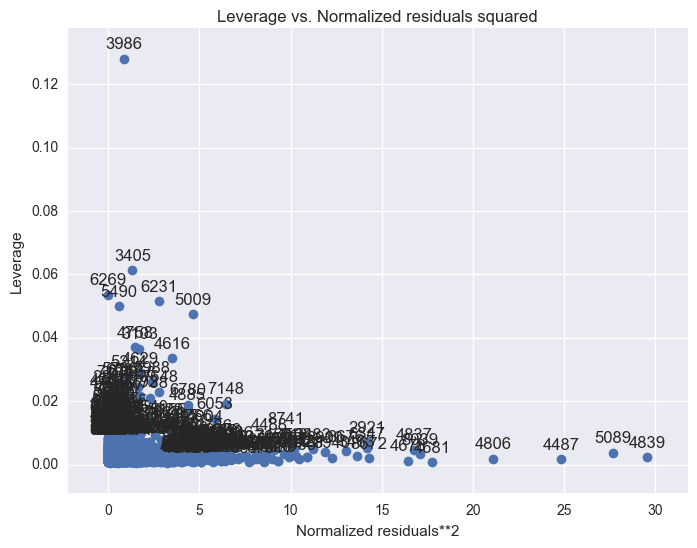

In [28]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(results, ax = ax)

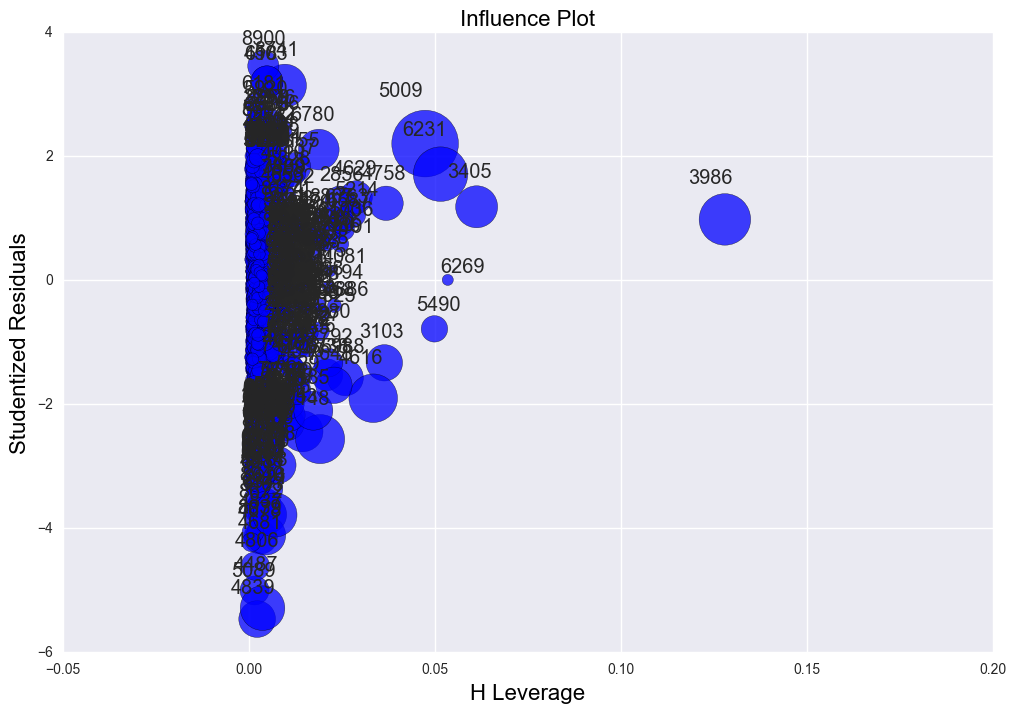

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(results, ax=ax, criterion="cooks")

There are a few worrisome observations. 3987 has a small residual, but a large leverage value. Several other points seem to have high positive or negative residuals as less (greater than or less than -2/+2)

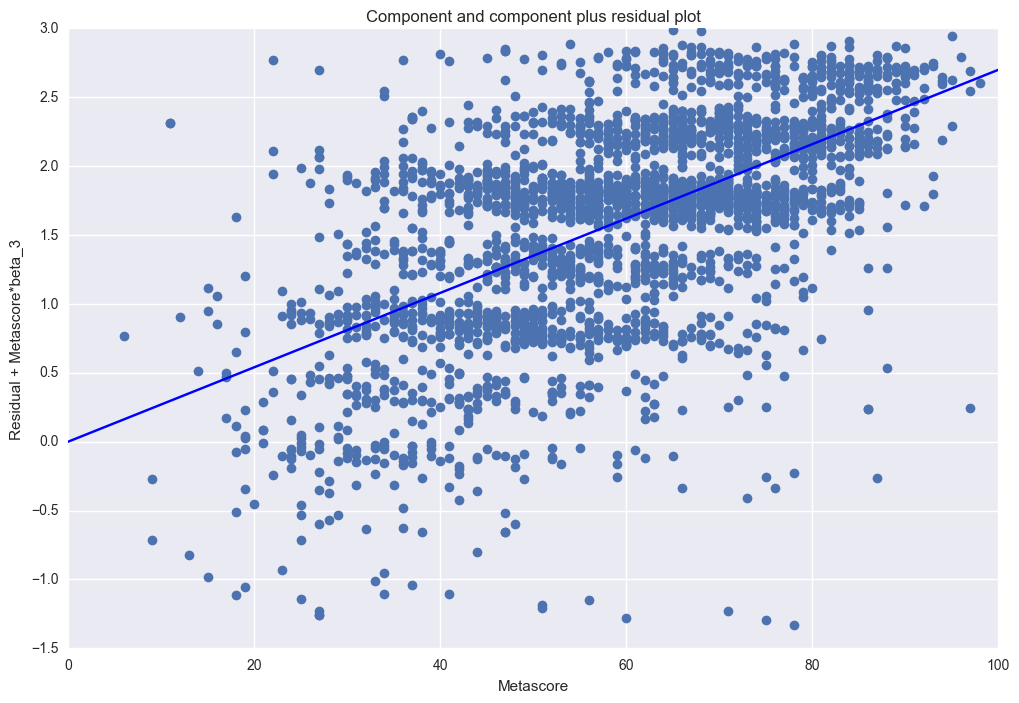

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_ccpr(results, "Metascore", ax=ax)

As you can see, the relationship between Ebert Stars explained by Metascore conditional on the other variables seems to be linear, though there are several other observations that are exerting considerable influence on the relationship.

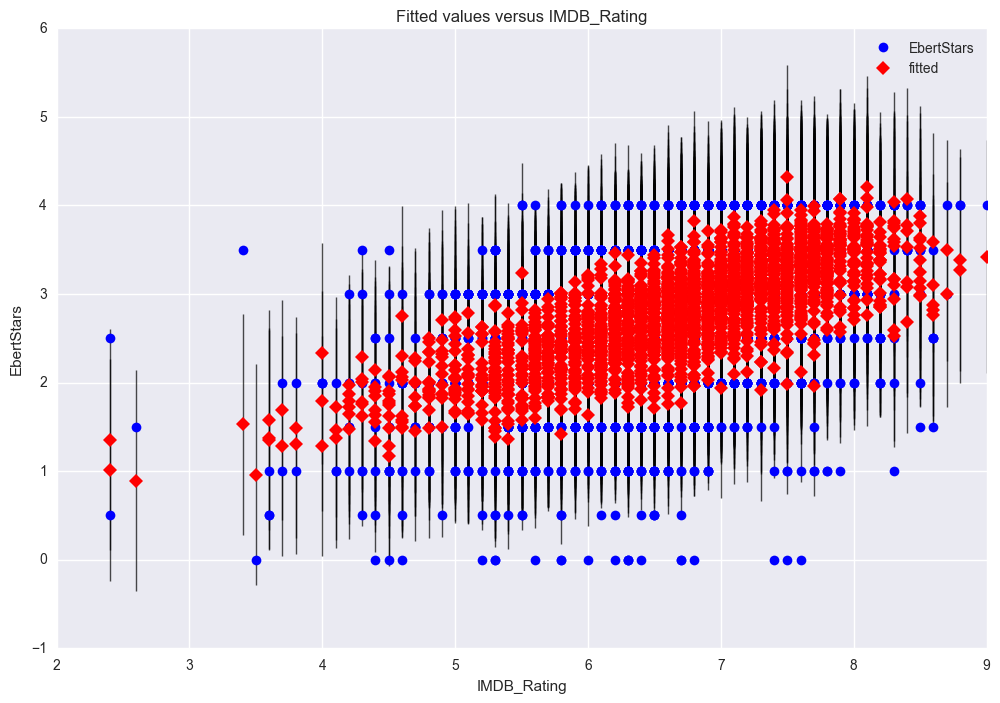

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(results, "IMDB_Rating", ax=ax)

We can see the fitted values vs. a choosen independent variable, which in this case is IMDB Rating. You can see the prediction confidence intervals as well.

In [32]:
predictions = results.predict(sm.add_constant(X_test))
print('Mean Squared Error: ', mean_squared_error(predictions, y_test))

Mean Squared Error:  0.412829032456


We actually got a lower mean squared error on the test set, which indicates we do not have over-fitting. Also, there is a significant improvement over the baseline model, so we know that the features are useful in predicting Ebert Star ratings.

## Predict Post-Ebert movies 

In [33]:
X = ebert.drop('EbertStars', axis=1)
y = ebert['EbertStars']

X_post = post_ebert.drop('EbertStars', axis=1)
y_post = post_ebert['EbertStars']

In [34]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.params)
results.summary()

const                  3.498790e-01
IMDB_Rating            7.443335e-02
Rating_Count          -2.824277e-07
Metascore              2.768773e-02
User_Review_Count      1.841553e-05
Critic_Review_Count    2.164765e-04
Runtime                4.018375e-03
UC_Ratio              -1.945114e-02
Description_Len       -1.398723e-03
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             EbertStars   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     338.6
Date:                Sat, 26 Aug 2017   Prob (F-statistic):               0.00
Time:                        16:06:19   Log-Likelihood:                -3836.7
No. Observations:                3983   AIC:                             7691.
Df Residuals:                    3974   BIC:                             7748.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3499      0.106      3.303      0.001       0.142       0.558
IMDB_Rating             0.0744      0.018      4.156      0.000       0.039       0.110
Rating_Count        -2.824e-07    1.3e-07     -2.176      0.030   -5.37e-07    -2.8e-08
Metascore               0.0277      0.001     30.894      0.000       0.026       0.029
User_Review_Count    1.842e-05   6.89e-05      0.267      0.789      -0.000       0.000
Critic_Review_Count     0.0002      0.000      1.377      0.169   -9.18e-05       0.001
Runtime                 0.0040      0.001      6.653      0.000       0.003       0.005
UC_Ratio               -0.0195      0.013     -1.539      0.124      -0.044       0.005
Description_Len        -0.0014      0.001     -1.944      0.052      -0.003    1.16e-05
==============================================================================
Omnibus:                      375.699   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              658.451
Skew:                          -0.660   Prob(JB):                    1.05e-143
Kurtosis:                       4.492   Cond. No.                     1.73e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
predictions = results.predict(sm.add_constant(X))
print('Mean Squared Error: ', mean_squared_error(predictions, y))

Mean Squared Error:  0.401977297007


In [36]:
predictions = results.predict(sm.add_constant(X_post))
print('Mean Squared Error: ', mean_squared_error(predictions, y_post))

Mean Squared Error:  0.48544879855


# Modeling (Lasso Regression with Genres, Directors, Actors, Decades)

Now let's create an initial model with all features, including those high-dimensional ones like directors and actors. We'll use Scikit-learn and Lasso to perform automatic feature subset selection.

Also, let's focus on predicting Ebert's ratings only (e.g., those before 2013).

In [37]:
regression_df = ebert_imdb_df\
    .drop(['Title', 'Description', 'URL', 'Country', 'Review', 'Release_Date', 
           'Season', 'Rating', 'Runtime', 'Review_Len'], axis=1)
    
regression_df = regression_df[regression_df['Year'] < 2013]
regression_df.shape

(6105, 4855)

In [38]:
print('IMDB_Rating', ebert_imdb_df['IMDB_Rating'].isnull().sum())
print('Rating_Count', ebert_imdb_df['Rating_Count'].isnull().sum())
print('Metascore', ebert_imdb_df['Metascore'].isnull().sum())
print('User_Review_Count', ebert_imdb_df['User_Review_Count'].isnull().sum())
print('Critic_Review_Count', ebert_imdb_df['Critic_Review_Count'].isnull().sum())
print('EbertStars', ebert_imdb_df['EbertStars'].isnull().sum())
print('Year', ebert_imdb_df['Year'].isnull().sum())
print('Runtime', ebert_imdb_df['Runtime'].isnull().sum())
print('UC_Ratio', ebert_imdb_df['UC_Ratio'].isnull().sum())

IMDB_Rating 22
Rating_Count 22
Metascore 2117
User_Review_Count 93
Critic_Review_Count 0
EbertStars 0
Year 0
Runtime 380
UC_Ratio 93


We can see that Metascore is the feature with the highest number of `NaN` values. Although it would be nice to keep all that data it is likely that Metascore will be selected by Lasso for being a good predictor.

In [39]:
regression_df = regression_df.dropna()
regression_df.shape

(4097, 4855)

Unfortunately, after removing `NaN` values we go from over 6400 movies to under 4000 movies.

Let's also play around with a couple of promising features (e.g., IMDB Rating and Metascore). Let's create some artificial features based on these 2 and see whether Lasso picks them as good predictors.

In [40]:
regression_df['IMDB_Squared'] = regression_df['IMDB_Rating'] ** 2
regression_df['Metascore_Squared'] = regression_df['Metascore'] ** 2
regression_df['IMDB*Metascore'] = regression_df['IMDB_Rating'] * regression_df['Metascore']

In [41]:
regression_df.head()

,IMDB_Rating,Rating_Count,Metascore,User_Review_Count,Critic_Review_Count,EbertStars,Year,Foreign,UC_Ratio,Description_Len,...,1950,1960,1970,1980,1990,2000,2010,IMDB_Squared,Metascore_Squared,IMDB*Metascore
85,5.7,55532.0,34.0,427.0,338.0,3.0,1999.0,0,1.263314,37,...,0,0,0,0,1,0,0,32.49,1156.0,193.8
164,5.3,22768.0,43.0,223.0,164.0,3.5,2001.0,0,1.359756,41,...,0,0,0,0,0,1,0,28.09,1849.0,227.9
178,5.9,153755.0,49.0,608.0,171.0,1.5,2006.0,0,3.555556,51,...,0,0,0,0,0,1,0,34.81,2401.0,289.1
180,4.8,3491.0,45.0,38.0,88.0,1.5,1996.0,0,0.431818,28,...,0,0,0,0,1,0,0,23.04,2025.0,216.0
196,6.6,1633.0,75.0,29.0,57.0,3.0,2011.0,0,0.508772,51,...,0,0,0,0,0,0,1,43.56,5625.0,495.0


In [42]:
train, test = train_test_split(regression_df, test_size=0.15, random_state=2)
X_train = train.drop(['EbertStars'], axis=1)
y_train = train['EbertStars']
X_test = test.drop(['EbertStars'], axis=1)
y_test = test['EbertStars']

## Lasso

[Lasso Regularization](http://scikit-learn.org/stable/modules/linear_model.html#lasso) (which uses `L1` penalty) is very useful when we have high-dimensional data and a sparse solution like we believe to be the case here. Instead of just reducing the coefficients like Ridge Regression (which uses `L2` penalty) does it actually brings them to zero if the feature is not a good predictor — effectively accomplishing feature subset selection.

Scikit-learn's [`Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) class takes as hyperparameter `alpha` which is a constant that multiplies the `L1` term. If `alpha=0` then it uses all the original features. As `alpha` increases, Lasso selects fewer and fewer features.

Following is an algorithm to select `alpha` so that it maximizes `R`<sup>2</sup>. Let's also make sure we normalize the data so that we don't have high values like `Runtime` alongside low ones like the dummy variables.

In [43]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
import decimal
import math

def lasso_r2_score(alpha):
    lasso = linear_model.Lasso(alpha=alpha, normalize=True)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    return lasso, r2_score(y_test, y_pred)

def n_selected_features(lasso):
    selected_features_idx = np.where(lasso.coef_ != 0)[0]
    return len(selected_features_idx)

def remove_float_inconsistency(float_):
    float_str = str(float_)
    return float(float_str)

def log(alpha, verbose):
    if verbose:
        print('calculating r2 with alpha={}'.format(alpha))

def lasso_best_alpha(alpha_min=0, alpha_max=0.01, verbose=False):
    """
    This function tries to find the best value for Lasso's hyperparameter 'alpha'.
    
    It iterates over ranges of ever smaller decimal values and only stops when the best and
    second best alpha values found yield a Lasso model with the same number of features.
    """
    best_lasso = None
    step = decimals = 10 ** (decimal.Decimal(str(alpha_max)).as_tuple().exponent - 1)
    while True:
        best_r2 = -math.inf
        second_best_r2 = -math.inf
        best_alpha = -1
        second_best_alpha = -1
        for alpha in np.arange(alpha_min, alpha_max+step, step):
            if alpha == 0:
                continue
            
            alpha = remove_float_inconsistency(alpha)
            alpha_max = remove_float_inconsistency(alpha_max)
            alpha_min = remove_float_inconsistency(alpha_min)
            log(alpha, verbose)
            lasso, r2 = lasso_r2_score(alpha)
            
            if r2 > best_r2:
                second_best_r2 = best_r2
                best_r2 = r2
                second_best_alpha = best_alpha
                best_alpha = alpha
                second_best_lasso = best_lasso
                best_lasso = lasso
            else:
                previous_second_best = second_best_r2
                if r2 > second_best_r2:
                    second_best_r2 = r2
                    second_best_alpha = alpha
                    second_best_lasso = lasso
                break
        
        if best_alpha == alpha_max:
            lower_level_alpha = best_alpha + step
            log(lower_level_alpha, verbose)
            lower_level_lasso, lower_level_r2 = lasso_r2_score(lower_level_alpha)
            
            if lower_level_r2 > second_best_r2:
                second_best_alpha = lower_level_alpha
                second_best_lasso = lower_level_lasso
                second_best_r2 = lower_level_r2
                alpha_max = best_alpha + step
                alpha_min = best_alpha
                
        elif best_alpha == alpha_min or (alpha_min == 0 and best_alpha == step):
            if alpha_min == 0:
                lower_level_alpha = best_alpha - step/10
            else:
                lower_level_alpha = best_alpha - step

            log(lower_level_alpha, verbose)
            lower_level_lasso, lower_level_r2 = lasso_r2_score(lower_level_alpha)
            
            if lower_level_r2 > second_best_r2:
                second_best_alpha = lower_level_alpha
                second_best_lasso = lower_level_lasso
                second_best_r2 = lower_level_r2
                alpha_max = best_alpha
                alpha_min = best_alpha - step
        else:
            alpha_max = max(best_alpha, second_best_alpha)
            alpha_min = min(best_alpha, second_best_alpha)
            
        step = step / 10
        
        if n_selected_features(best_lasso) == n_selected_features(second_best_lasso):
            return best_lasso, best_r2

In [44]:
lasso, r2 = lasso_best_alpha(verbose=True)

calculating r2 with alpha=0.001
calculating r2 with alpha=0.002
calculating r2 with alpha=0.0009


In [45]:
print('alpha =', lasso.alpha)
print('r2 =', r2)

alpha = 0.001
r2 = 0.415234967378


We can see that after trying multiple values for `alpha` the algorithm chose 0.0002611 which yields a Lasso Regression model with an `R`<sup>2</sup> of 0.4873062371.

Now let's see how many and which features were selected by Lasso.

In [46]:
selected_features_idx = np.where(lasso.coef_ != 0)[0]
print(len(selected_features_idx))

selected_features = X_train.iloc[:, selected_features_idx]
selected_features.columns.values

11


array(['Metascore', 'Drama', 'Horror', 'Steven R. Monroe',
       'Allen Danziger', 'Andrew Howard', 'Edwin Neal', 'Jeff Branson',
       'Marilyn Burns', 'Sarah Butler', 'IMDB*Metascore'], dtype=object)

At 393 this is about only 8% of the 4801 features we originally fed the algorithm with.

Besides many actors and directors, Lasso kept as good predictors the following features: 
- `IMDB_Rating`
- `Metascore`
- `Runtime`
- `Foreign`
- `UC_Ratio`
- `Review_Len`
- `Spring`
- `PG`
- `PG-13`
- `1960`
- `2010`
- `Animation`
- `Comedy`
- `Crime`
- `Drama`
- `Horror`
- `Sci-Fi`
- `Western`

Before we move on and calculate the Mean Squared Error, let's have a glympse at the final array of coefficients generated by Lasso (which contains 0's for features not selected).

In [47]:
lasso.coef_[:20]

array([ 0.        ,  0.        ,  0.02098865,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ])

Moreover, once we had the best value for `alpha` this is how many iterations of the Lasso algorithm were necessary to reach the final model:

In [48]:
lasso.n_iter_

111

In [49]:
y_pred_train = lasso.predict(X_train)
print('train dataset r2 score:', r2_score(y_train, y_pred_train))
print('train dataset mean squared error:', mean_squared_error(y_train, y_pred_train))

train dataset r2 score: 0.38894056456
train dataset mean squared error: 0.418748800661


In [50]:
y_pred = lasso.predict(X_test)
print('test dataset r2 score:', r2_score(y_test, y_pred))
print('test dataset mean squared error:', mean_squared_error(y_test, y_pred))

test dataset r2 score: 0.415234967378
test dataset mean squared error: 0.384503204582


We could further improve this model by using cross-validation to choose a good `alpha` (i.e., with the [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) class). However, since the train dataset `R`<sup>2</sup> is not even close to a good value like `0.9` the main problem with this model is that it is underfitting as opposed to overfitting. Let's plot the [learning curves](http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve) to see if we can confirm that.

In [51]:
# adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curves(train_sizes, train_scores, test_scores):
    plt.figure(figsize=(11, 9))
    plt.title("Learning Curves")
    plt.xlabel("Number of examples")
    plt.ylabel("$R^2$")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training $R^2$")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test $R^2$")

    plt.legend(loc="best")
    plt.show()

In [55]:
# TAKES A LONG TIME TO RUN
# from sklearn.model_selection import learning_curve

# X = regression_df.drop(['EbertStars'], axis=1)
# y = regression_df['EbertStars']
# train_sizes, train_scores, test_scores = learning_curve(lasso, X, y, n_jobs=-1)

In [54]:
# plot_learning_curves(train_sizes, train_scores, test_scores)

We can see from the plot that we are indeed underfitting as both curves should converge further (similar to these [learning curves](http://scikit-learn.org/stable/_images/sphx_glr_plot_learning_curve_001.png)). If on one side, dropping that many examples that didn't have a Metascore hurt the model, on the other hand dropping the Metascore feature would also hurt. Anyhow, giving that our training `R`<sup>2</sup> is low, even if we had more data we would have a model that couldn't predict so well.

# Conclusions, Lessons Learned and Further Research

The latter model with the addition of high-dimensional features like Actors, Directors and Genres, as well as feature subset selection performed by Lasso yielded a better model with higher `R`<sup>2</sup> and lower Mean Squared Error than what we could accomplish before.

However, it is not that much better on the test set and, even worse, it is not good enough on the train set. That indicates we're either missing some highly predictive features (i.e., budget, box office, screenwriter, studio, awards won by movies/actors/directors, whether a movie is part of a series) or that maybe this problem is not linear and that we should try alternative Machine Learning algorithms in the future (i.e., Tree-based methods, SVM, Neural Networks).

It could also be the case that Ebert's ratings were grounded in much more subjective matters that not even adding the proposed new features or trying alternative Machine Learning methods were going to yield predictions with much lower error.

Nonetheless, another are of further research could be to model this problem as a Classification problem (as opposed to a Regression one). After all, Eberts' ratings were discrete, with 9 possible values ranging from 0 to 4.